# 图像分类迁移学习

<a href="https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/middleclass/image_and_video/transfer_learning.ipynb" target="_blank"><img src="https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png"></a>

在实际场景中，很少有人会选择从头训练整个网络，大多数情况下会基于已有的模型来进行迁移学习。本章将会以蚂蚁和蜜蜂的图像分类为例，讲解如何在MindSpore中加载预训练模型，并通过固定权重来实现迁移学习的目的。

## 准备环节

首先，我们导入相关的模块，并配置运行信息。这里采用`GRAPH_MODE`运行，硬件环境为`GPU`。

In [1]:
import os
import math
import stat
import numpy as np

import mindspore.ops as ops
from mindspore.dataset.vision import Inter
from mindspore.nn import Accuracy
from mindspore.common.initializer import Normal
import mindspore.nn as nn
from mindspore import Model, Tensor, context
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2
from  mindspore import dtype as mstype

In [2]:
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

### 数据集准备

下载案例所用到的[蚂蚁与蜜蜂分类数据集](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/middleclass/hymenoptera_data.zip)，数据集中的图像来自于ImageNet，每个分类有大约120张训练图像与75张验证图像。将下载后的数据集放置在当前目录下：
```
project
│  transfer_learning.ipynb
│  resnet50.ckpt.ipynb     
└─data
   └─hymenoptera_data
      └─train
      │   └─ants
      │   │  bees
      └─val
          └─ants
          │  bees
```

### 下载预训练模型

下载[预训练模型的ckpt文件](https://download.mindspore.cn/model_zoo/official/cv/resnet/resnet50_v1.5_ascend_0.3.0_cifar10_official_classification_20200718/resnet50.ckpt)，将其放在上述目录。

可在Jupyter Notebook中执行如下命令，完成数据集和预训练模型的下载，并放置到指定位置：

In [ ]:
!mkdir -p ./data/
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/middleclass/hymenoptera_data.zip
!wget -N https://download.mindspore.cn/model_zoo/official/cv/resnet/resnet50_v1.5_ascend_0.3.0_cifar10_official_classification_20200718/resnet50.ckpt
!unzip -n ./hymenoptera_data.zip -d ./data/

## 加载数据

定义`create_dataset`函数来处理数据。

In [3]:
train_data_path = 'data/hymenoptera_data/train'
val_data_path = 'data/hymenoptera_data/val'

In [4]:
def create_dataset(data_path, batch_size=4, repeat_num=1,training=True):
    """定义数据集"""
    data_set = ds.ImageFolderDataset(data_path, num_parallel_workers=8, shuffle=True)
    image_size = 224
    mean = [0.485*255 , 0.456*255 , 0.406*255]
    std = [0.229*255, 0.224*255, 0.225*255]
    if training:
        trans = [
                C.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
                C.RandomHorizontalFlip(prob=0.5),
                C.Normalize(mean=mean, std=std),
                C.HWC2CHW()
                ]
    else:
        trans = [
                C.Decode(),
                C.Resize(256),
                C.CenterCrop(image_size),
                C.HWC2CHW()
                ]
    type_cast_op = C2.TypeCast(mstype.int32)
    # 实现dataset的映射和批量处理
    data_set = data_set.map(operations=trans, input_columns="image", num_parallel_workers=8)
    data_set = data_set.map(operations=type_cast_op, input_columns="label", num_parallel_workers=8)
    data_set = data_set.batch(batch_size, drop_remainder=True)
    data_set = data_set.repeat(repeat_num)

    return data_set

In [5]:
# 实例化数据集
train_ds =  create_dataset(train_data_path)

### 可视化图像

让我们可视化一些训练图像，来观察处理后的数据。

Tensor of image (4, 3, 224, 224)
Labels: [1 0 1 1]


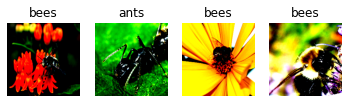

In [6]:
import matplotlib.pyplot as plt

data = next(train_ds.create_dict_iterator())
images = data["image"]
labels = data["label"]
print("Tensor of image", images.shape)
print("Labels:",labels)
class_name = {0:"ants",1:"bees"}
count = 1
# 输出测试图
for i in images:
    plt.subplot(1,4,count)
    plt.imshow(i.asnumpy().transpose(1,2,0))
    plt.title(class_name[int(labels[count-1].asnumpy())])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()

## 定义网络

### 定义网络相关的计算模块
通过定义计算模块，为网络提供权重变化和学习增益的更新。

In [7]:
def _conv_variance_scaling_initializer(in_channel, out_channel, kernel_size):
    """方差缩放初始化设定"""
    fan_in = in_channel * kernel_size * kernel_size
    scale = 1.0
    scale /= max(1., fan_in)
    stddev = (scale ** 0.5) / .87962566103423978
    mu, sigma = 0, stddev
    weight = truncnorm(-2, 2, loc=mu, scale=sigma).rvs(out_channel * in_channel * kernel_size * kernel_size)
    weight = np.reshape(weight, (out_channel, in_channel, kernel_size, kernel_size))
    return Tensor(weight, dtype=mstype.float32)


def _weight_variable(shape, factor=0.01):
    """权重变化"""
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)

def calculate_gain(nonlinearity, param=None):
    """计算增益"""
    linear_fns = ['linear', 'conv1d', 'conv2d', 'conv3d', 'conv_transpose1d', 'conv_transpose2d', 'conv_transpose3d']
    res = 0
    # 判断线性函数方法
    if nonlinearity in linear_fns or nonlinearity == 'sigmoid':
        res = 1
    elif nonlinearity == 'tanh':
        res = 5.0 / 3
    elif nonlinearity == 'relu':
        res = math.sqrt(2.0)
    elif nonlinearity == 'leaky_relu':
        if param is None:
            negative_slope = 0.01
        elif not isinstance(param, bool) and isinstance(param, int) or isinstance(param, float):
            negative_slope = param
        else:
            raise ValueError("negative_slope {} not a valid number".format(param))
        res = math.sqrt(2.0 / (1 + negative_slope ** 2))
    else:
        raise ValueError("Unsupported nonlinearity {}".format(nonlinearity))
    return res

def _calculate_fan_in_and_fan_out(tensor):
    """计算扇入和扇出"""
    dimensions = len(tensor)
    # 判断张量长度
    if dimensions < 2:
        raise ValueError("Fan in and fan out can not be computed for tensor with fewer than 2 dimensions")
    if dimensions == 2:  # 线性
        fan_in = tensor[1]
        fan_out = tensor[0]
    else:
        num_input_fmaps = tensor[1]
        num_output_fmaps = tensor[0]
        receptive_field_size = 1
        if dimensions > 2:
            receptive_field_size = tensor[2] * tensor[3]
        fan_in = num_input_fmaps * receptive_field_size
        fan_out = num_output_fmaps * receptive_field_size
    return fan_in, fan_out

def _calculate_correct_fan(tensor, mode):
    """更正函数计算"""
    mode = mode.lower()
    valid_modes = ['fan_in', 'fan_out']
    if mode not in valid_modes:
        raise ValueError("Mode {} not supported, please use one of {}".format(mode, valid_modes))
    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    return fan_in if mode == 'fan_in' else fan_out


def kaiming_normal(inputs_shape, a=0, mode='fan_in', nonlinearity='leaky_relu'):
    fan = _calculate_correct_fan(inputs_shape, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / math.sqrt(fan)
    return np.random.normal(0, std, size=inputs_shape).astype(np.float32)

def kaiming_uniform(inputs_shape, a=0., mode='fan_in', nonlinearity='leaky_relu'):
    fan = _calculate_correct_fan(inputs_shape, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / math.sqrt(fan)
    bound = math.sqrt(3.0) * std 
    return np.random.uniform(-bound, bound, size=inputs_shape).astype(np.float32)

### 定义卷积模块
通过定义网络所需要的卷积块，满足网络的卷积需求。

In [8]:
def _conv3x3(in_channel, out_channel, stride=1, use_se=False, res_base=False):
    """定义3*3卷积块"""
    if use_se:
        weight = _conv_variance_scaling_initializer(in_channel, out_channel, kernel_size=3)
    else:
        weight_shape = (out_channel, in_channel, 3, 3)
        weight = Tensor(kaiming_normal(weight_shape, mode="fan_out", nonlinearity='relu'))
    if res_base:
        return nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride,
                         padding=1, pad_mode='pad', weight_init=weight)
    return nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride,
                     padding=0, pad_mode='same', weight_init=weight)


def _conv1x1(in_channel, out_channel, stride=1, use_se=False, res_base=False):
    """定义1*1卷积块"""
    if use_se:
        weight = _conv_variance_scaling_initializer(in_channel, out_channel, kernel_size=1)
    else:
        weight_shape = (out_channel, in_channel, 1, 1)
        weight = Tensor(kaiming_normal(weight_shape, mode="fan_out", nonlinearity='relu'))
    if res_base:
        return nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride,
                         padding=0, pad_mode='pad', weight_init=weight)
    return nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride,
                     padding=0, pad_mode='same', weight_init=weight)



def _conv7x7(in_channel, out_channel, stride=1, use_se=False, res_base=False):
    """定义7*7卷积块"""
    if use_se:
        weight = _conv_variance_scaling_initializer(in_channel, out_channel, kernel_size=7)
    else:
        weight_shape = (out_channel, in_channel, 7, 7)
        weight = Tensor(kaiming_normal(weight_shape, mode="fan_out", nonlinearity='relu'))
    if res_base:
        return nn.Conv2d(in_channel, out_channel,
                         kernel_size=7, stride=stride, padding=3, pad_mode='pad', weight_init=weight)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)



### 定义网络层
为了构造ResNet网络，需要定义组成该网络所需的网络层。

In [9]:
def _bn(channel, res_base=False):
    """定义bn层"""
    if res_base:
        return nn.BatchNorm2d(channel, eps=1e-5, momentum=0.1,
                              gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _fc(in_channel, out_channel, use_se=False):
    """定义fc层"""
    if use_se:
        weight = np.random.normal(loc=0, scale=0.01, size=out_channel * in_channel)
        weight = Tensor(np.reshape(weight, (out_channel, in_channel)), dtype=mstype.float32)
    else:
        weight_shape = (out_channel, in_channel)
        weight = Tensor(kaiming_uniform(weight_shape, a=math.sqrt(5)))
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)

### 定义残差函数
为了防止网络退化问题，我们来定义残差函数。

In [10]:
class ResidualBlock(nn.Cell):
    """
    定义ResNet V1 残差函数
    """
    expansion = 4

    def __init__(self,
                 in_channel,
                 out_channel,
                 stride=1,
                 use_se=False, se_block=False):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.use_se = use_se
        self.se_block = se_block
        channel = out_channel // self.expansion
        self.conv1 = _conv1x1(in_channel, channel, stride=1, use_se=self.use_se)
        self.bn1 = _bn(channel)
        if self.use_se and self.stride != 1:
            self.e2 = nn.SequentialCell([_conv3x3(channel, channel, stride=1, use_se=True), _bn(channel),
                                         nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='same')])
        else:
            self.conv2 = _conv3x3(channel, channel, stride=stride, use_se=self.use_se)
            self.bn2 = _bn(channel)

        self.conv3 = _conv1x1(channel, out_channel, stride=1, use_se=self.use_se)
        self.bn3 = _bn_last(out_channel)
        if self.se_block:
            self.se_global_pool = ops.operations.ReduceMean(keep_dims=False)
            self.se_dense_0 = _fc(out_channel, int(out_channel / 4), use_se=self.use_se)
            self.se_dense_1 = _fc(int(out_channel / 4), out_channel, use_se=self.use_se)
            self.se_sigmoid = nn.Sigmoid()
            self.se_mul = ops.operations.Mul()
        self.relu = nn.ReLU()

        self.down_sample = False

        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None

        if self.down_sample:
            if self.use_se:
                if stride == 1:
                    self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel,
                                                                         stride, use_se=self.use_se), _bn(out_channel)])
                else:
                    self.down_sample_layer = nn.SequentialCell([nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='same'),
                                                                _conv1x1(in_channel, out_channel, 1,
                                                                         use_se=self.use_se), _bn(out_channel)])
            else:
                self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride,
                                                                     use_se=self.use_se), _bn(out_channel)])

    def construct(self, x):
        """
        定义ResNet V1残差函数
        """
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        if self.use_se and self.stride != 1:
            out = self.e2(out)
        else:
            out = self.conv2(out)
            out = self.bn2(out)
            out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.se_block:
            out_se = out
            out = self.se_global_pool(out, (2, 3))
            out = self.se_dense_0(out)
            out = self.relu(out)
            out = self.se_dense_1(out)
            out = self.se_sigmoid(out)
            out = ops.functional.reshape(out, ops.functional.shape(out) + (1, 1))
            out = self.se_mul(out, out_se)

        if self.down_sample:
            identity = self.down_sample_layer(identity)

        out = out + identity
        out = self.relu(out)

        return out

### 定义ResNet网络

In [11]:
class ResNet(nn.Cell):
    """
    定义ResNet
    """

    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 strides,
                 num_classes,
                 use_se=False,
                 res_base=False):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")
        self.use_se = use_se
        self.res_base = res_base
        self.se_block = False
        if self.use_se:
            self.se_block = True

        if self.use_se:
            self.conv1_0 = _conv3x3(3, 32, stride=2, use_se=self.use_se)
            self.bn1_0 = _bn(32)
            self.conv1_1 = _conv3x3(32, 32, stride=1, use_se=self.use_se)
            self.bn1_1 = _bn(32)
            self.conv1_2 = _conv3x3(32, 64, stride=1, use_se=self.use_se)
        else:
            self.conv1 = _conv7x7(3, 64, stride=2, res_base=self.res_base)
        self.bn1 = _bn(64, self.res_base)
        self.relu = ops.operations.ReLU()

        if self.res_base:
            self.pad = nn.Pad(paddings=((0, 0), (0, 0), (1, 1), (1, 1)))
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="valid")
        else:
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0],
                                       use_se=self.use_se)
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1],
                                       use_se=self.use_se)
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2],
                                       use_se=self.use_se,
                                       se_block=self.se_block)
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3],
                                       use_se=self.use_se,
                                       se_block=self.se_block)

        self.mean = ops.operations.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes, use_se=self.use_se)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride, use_se=False, se_block=False):
        """
        构造ResNet网络结构
        """
        layers = []

        resnet_block = block(in_channel, out_channel, stride=stride, use_se=use_se)
        layers.append(resnet_block)
        if se_block:
            for _ in range(1, layer_num - 1):
                resnet_block = block(out_channel, out_channel, stride=1, use_se=use_se)
                layers.append(resnet_block)
            resnet_block = block(out_channel, out_channel, stride=1, use_se=use_se, se_block=se_block)
            layers.append(resnet_block)
        else:
            for _ in range(1, layer_num):
                resnet_block = block(out_channel, out_channel, stride=1, use_se=use_se)
                layers.append(resnet_block)
        return nn.SequentialCell(layers)

    def construct(self, x):
        if self.use_se:
            x = self.conv1_0(x)
            x = self.bn1_0(x)
            x = self.relu(x)
            x = self.conv1_1(x)
            x = self.bn1_1(x)
            x = self.relu(x)
            x = self.conv1_2(x)
        else:
            x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.res_base:
            x = self.pad(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = self.mean(c5, (2, 3))
        out = self.flatten(out)
        out = self.end_point(out)

        return out

### 定义ResNet50网络
通过前面ResNet网络构造ResNet50网络。

In [12]:
def resnet50(class_num=10):
    """
    创建ResNet50神经网络
    """
    return ResNet(ResidualBlock,
              [3, 4, 6, 3],
              [64, 256, 512, 1024],
              [256, 512, 1024, 2048],
              [1, 2, 2, 2],
              class_num)

## 训练模型
现在，让我们自定义一个数据收集的回调类`EvalCallBack`，用于实现下面两种信息：
- 训练过程中，每一个epoch结束之后，训练集的损失值和验证集的模型精度。
- 保存精度最高的模型。


In [13]:
from mindspore import save_checkpoint
from mindspore.train.callback import TimeMonitor, Callback, LossMonitor

def apply_eval(eval_param):
    eval_model = eval_param['model']
    eval_ds = eval_param['dataset']
    metrics_name = eval_param['metrics_name']
    res = eval_model.eval(eval_ds)
    return res[metrics_name]

class EvalCallBack(Callback):
    """
    回调训练评价类
    """

    def __init__(self, eval_function, eval_param_dict, interval=1, eval_start_epoch=1, save_best_ckpt=True,
                 ckpt_directory="./", besk_ckpt_name="best.ckpt", metrics_name="acc", num_epochs=20):
        super(EvalCallBack, self).__init__()
        self.eval_param_dict = eval_param_dict
        self.eval_function = eval_function
        self.eval_start_epoch = eval_start_epoch
        if interval < 1:
            raise ValueError("interval should >= 1.")
        self.interval = interval
        self.save_best_ckpt = save_best_ckpt
        self.best_res = 0
        self.best_epoch = 0
        if not os.path.isdir(ckpt_directory):
            os.makedirs(ckpt_directory)
        self.best_ckpt_path = os.path.join(ckpt_directory, besk_ckpt_name)
        self.metrics_name = metrics_name

    def remove_ckpoint_file(self, file_name):
        """每轮训练后只保留精度最好的ckpt文件"""
        os.chmod(file_name, stat.S_IWRITE)
        os.remove(file_name)
    def epoch_end(self, run_context):
        """训练反馈"""
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        loss_epoch =  cb_params.net_outputs
        if cur_epoch >= self.eval_start_epoch and (cur_epoch - self.eval_start_epoch) % self.interval == 0:
            res = self.eval_function(self.eval_param_dict)
            print('Epoch {}/{}'.format(cur_epoch, num_epochs))
            print('-' * 10)
            print('train Loss: {}'.format(loss_epoch))
            print('val Acc: {}'.format(res))
            if res >= self.best_res:
                self.best_res = res
                self.best_epoch = cur_epoch
                if self.save_best_ckpt:
                    if os.path.exists(self.best_ckpt_path):
                        self.remove_ckpoint_file(self.best_ckpt_path)
                    save_checkpoint(cb_params.train_network, self.best_ckpt_path)
    def end(self, run_context):
        print("End training, the best {0} is: {1}, the best {0} epoch is {2}".format(self.metrics_name,
                                                                                     self.best_res,
                                                                                     self.best_epoch), flush=True)

### 可视化模型预测

通过下面的函数，展示一些预测图像，并删除项目中需要重置的参数。

In [14]:
from mindspore import load_checkpoint, load_param_into_net

def visualize_model(best_ckpt_path,val_ds):
    """实例化网络"""
    net = resnet50(2)
    param_dict = load_checkpoint(best_ckpt_path)
    load_param_into_net(net,param_dict)
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True,reduction='mean')
    model = Model(net, loss,metrics={"Accuracy":Accuracy()})
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    class_name = {0:"ants",1:"bees"}
    output = model.predict(Tensor(data['image']))
    pred = np.argmax(output.asnumpy(),axis=1)
    err_num = []
    index = 1
    # 展示预测图像
    for i in range(len(labels)):
        plt.subplot(2,2,i+1)
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('pre:{}'.format(class_name[pred[i]]), color=color)
        plt.imshow(images[i].transpose(1,2,0))
        plt.axis('off')

In [15]:
def filter_checkpoint_parameter_by_list(origin_dict, param_filter):
    """从训练好的ckpt文件里删除需要重置的参数"""
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break

## 模型微调

加载预训练的模型并重置最终的全连接层。

In [16]:
net = resnet50(2)
num_epochs=20
param_dict = load_checkpoint('resnet50.ckpt')
filter_list = [x.name for x in net.end_point.get_parameters()]
filter_checkpoint_parameter_by_list(param_dict, filter_list)
load_param_into_net(net,param_dict)
opt = nn.Momentum(params=net.trainable_params(), learning_rate=0.001, momentum=0.9)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True,reduction='mean')
model = Model(net, loss,opt,metrics={"Accuracy":Accuracy()})

Delete parameter from checkpoint:  end_point.weight
Delete parameter from checkpoint:  end_point.bias
Delete parameter from checkpoint:  moments.end_point.weight
Delete parameter from checkpoint:  moments.end_point.bias


### 训练和评估

运行下面代码，开始模型训练。

In [17]:
train_ds =  create_dataset(train_data_path)
val_ds = create_dataset(val_data_path)
eval_param_dict = {"model":model,"dataset":val_ds,"metrics_name":"Accuracy"}
eval_cb = EvalCallBack(apply_eval, eval_param_dict,)
model.train(num_epochs,train_ds, callbacks=[eval_cb, TimeMonitor()], dataset_sink_mode=False)

Epoch 1/20
----------
train Loss: 0.9686852
val Acc: 0.7105263157894737
epoch time: 12580.445 ms, per step time: 206.237 ms
Epoch 2/20
----------
train Loss: 0.44091043
val Acc: 0.6118421052631579
epoch time: 5018.593 ms, per step time: 82.272 ms
Epoch 3/20
----------
train Loss: 0.910527
val Acc: 0.7105263157894737
epoch time: 5521.028 ms, per step time: 90.509 ms
Epoch 4/20
----------
train Loss: 0.5526486
val Acc: 0.7236842105263158
epoch time: 5453.967 ms, per step time: 89.409 ms
Epoch 5/20
----------
train Loss: 0.5758235
val Acc: 0.7236842105263158
epoch time: 5440.765 ms, per step time: 89.193 ms
Epoch 6/20
----------
train Loss: 0.426515
val Acc: 0.6842105263157895
epoch time: 5027.957 ms, per step time: 82.426 ms
Epoch 7/20
----------
train Loss: 0.33777326
val Acc: 0.7631578947368421
epoch time: 5399.855 ms, per step time: 88.522 ms
Epoch 8/20
----------
train Loss: 0.9343228
val Acc: 0.756578947368421
epoch time: 5115.569 ms, per step time: 83.862 ms
Epoch 9/20
----------
t

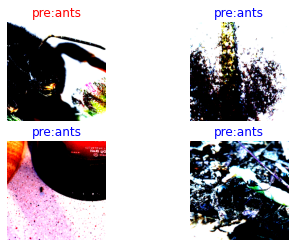

In [18]:
visualize_model('best.ckpt',val_ds)

## 固定特征进行训练 

在这里，我们需要冻结除最后一层之外的所有网络。 设置`requires_grad == False`冻结参数，以便不在反向传播中计算梯度。


In [19]:
net = resnet50(2)
num_epochs=20
param_dict = load_checkpoint('resnet50_ascend_v111.ckpt')
filter_list = [x.name for x in net.end_point.get_parameters()]
filter_checkpoint_parameter_by_list(param_dict, filter_list)
load_param_into_net(net,param_dict)
for param in net.get_parameters():
    if param.name not in ["end_point.weight","end_point.bias"]:
         param.requires_grad = False
opt = nn.Momentum(params=net.trainable_params(), learning_rate=0.1, momentum=0.9)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True,reduction='mean')
model = Model(net, loss,opt,metrics={"Accuracy":Accuracy()})

Delete parameter from checkpoint:  end_point.weight
Delete parameter from checkpoint:  end_point.bias
Delete parameter from checkpoint:  moments.end_point.weight
Delete parameter from checkpoint:  moments.end_point.bias


### 训练和评估

与没有预训练模型相比，将节约一大半时间，因为此时可以不用计算部分梯度。

In [20]:
train_ds =  create_dataset(train_data_path)
val_ds = create_dataset(val_data_path)
eval_param_dict = {"model":model,"dataset":val_ds,"metrics_name":"Accuracy"}
eval_cb = EvalCallBack(apply_eval, eval_param_dict,)
model.train(num_epochs,train_ds, callbacks=[eval_cb, TimeMonitor()], dataset_sink_mode=False)

Epoch 1/20
----------
train Loss: 18.609592
val Acc: 0.6381578947368421
epoch time: 7167.215 ms, per step time: 117.495 ms
Epoch 2/20
----------
train Loss: 11.478684
val Acc: 0.5592105263157895
epoch time: 2681.014 ms, per step time: 43.951 ms
Epoch 3/20
----------
train Loss: 0.2935766
val Acc: 0.5328947368421053
epoch time: 2586.290 ms, per step time: 42.398 ms
Epoch 4/20
----------
train Loss: 7.7069426
val Acc: 0.5723684210526315
epoch time: 2573.789 ms, per step time: 42.193 ms
Epoch 5/20
----------
train Loss: 5.1382387e-05
val Acc: 0.6644736842105263
epoch time: 2740.495 ms, per step time: 44.926 ms
Epoch 6/20
----------
train Loss: 16.870192
val Acc: 0.5789473684210527
epoch time: 2570.333 ms, per step time: 42.137 ms
Epoch 7/20
----------
train Loss: 8.476288
val Acc: 0.6118421052631579
epoch time: 2616.749 ms, per step time: 42.898 ms
Epoch 8/20
----------
train Loss: 14.265462
val Acc: 0.6776315789473685
epoch time: 2886.543 ms, per step time: 47.320 ms
Epoch 9/20
---------

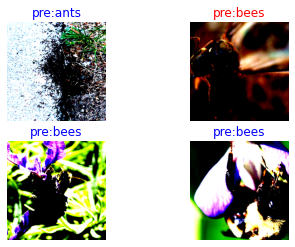

In [21]:
visualize_model('best.ckpt',val_ds)